In [1]:
import sys 
sys.path.append("../")

In [2]:
from mps_utils import * 
from wave_circuit import * 
import matplotlib.pyplot as plt 
import pickle

In [3]:
f1 = lambda x :  np.exp(-(x-0.45)**2/0.01)
df1 = lambda x: ( -2 * (x-0.45)/(0.01) ) * f1(x)

f2 = lambda x :  (x-0.45)/0.05 * f1(x)
df2 = lambda x: (x-0.45)/0.05 * df1(x) + 1/0.05 * f1(x)

f3 = lambda x: (1-(x-0.45)**2/0.01) * f1(x)
df3 = lambda x: -2*(x-0.45)/0.01 * f1(x) + (1-(x-0.45)**2/0.01)*df1(x)

m = 5
l = 2**m
x_coarse = np.linspace(0,1,l+1)

In [4]:
with open("mps_opt", 'rb') as file:
    layers_opt1, layers_opt2,layers_opt3 = pickle.load(file)

with open("mps_trunc", 'rb') as file:
    layers_trunc1, layers_trunc2, layers_trunc3 = pickle.load(file)

n = 9
N = 2**n
x = np.linspace(0, 1 - 1/N, N)


In [5]:
from qiskit.circuit import Parameter, QuantumCircuit 

t  = Parameter('t')

M1_evo_circ = QuantumCircuit(n+2)
M1_evo_circ = M1_evo_circ.compose(circ_from_layers(layers_trunc1[-1]),range(2,n+2))
M1_evo_circ = M1_evo_circ.compose(evolve_circ(n,t),range(0,n+2))

M2_evo_circ = QuantumCircuit(n+2)
M2_evo_circ = M2_evo_circ.compose(circ_from_layers(layers_trunc2[-1]),range(2,n+2))
M2_evo_circ = M2_evo_circ.compose(evolve_circ(n,t),range(0,n+2))

M3_evo_circ = QuantumCircuit(n+2)
M3_evo_circ = M3_evo_circ.compose(circ_from_layers(layers_trunc3[-1]),range(2,n+2))
M3_evo_circ = M3_evo_circ.compose(evolve_circ(n,t),range(0,n+2))

circs = [M1_evo_circ,M2_evo_circ,M3_evo_circ]


M1_evo_circ_opt = QuantumCircuit(n+2)
M1_evo_circ_opt = M1_evo_circ_opt.compose(circ_from_layers(layers_opt1),range(2,n+2))
M1_evo_circ_opt = M1_evo_circ_opt.compose(evolve_circ(n,t),range(0,n+2))

M2_evo_circ_opt = QuantumCircuit(n+2)
M2_evo_circ_opt = M2_evo_circ_opt.compose(circ_from_layers(layers_opt2),range(2,n+2))
M2_evo_circ_opt = M2_evo_circ_opt.compose(evolve_circ(n,t),range(0,n+2))

M3_evo_circ_opt = QuantumCircuit(n+2)
M3_evo_circ_opt = M3_evo_circ_opt.compose(circ_from_layers(layers_opt3),range(2,n+2))
M3_evo_circ_opt = M3_evo_circ_opt.compose(evolve_circ(n,t),range(0,n+2))

circs_opt = [M1_evo_circ_opt,M2_evo_circ_opt,M3_evo_circ_opt]

C:\Users\bik19\AppData\Local\Temp\ipykernel_5476\2730427103.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", time_steps)
C:\Users\bik19\AppData\Local\Temp\ipykernel_5476\2730427103.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap("cool", time_steps)
C:\Users\bik19\AppData\Local\Temp\ipykernel_5476\2730427103.py:66: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


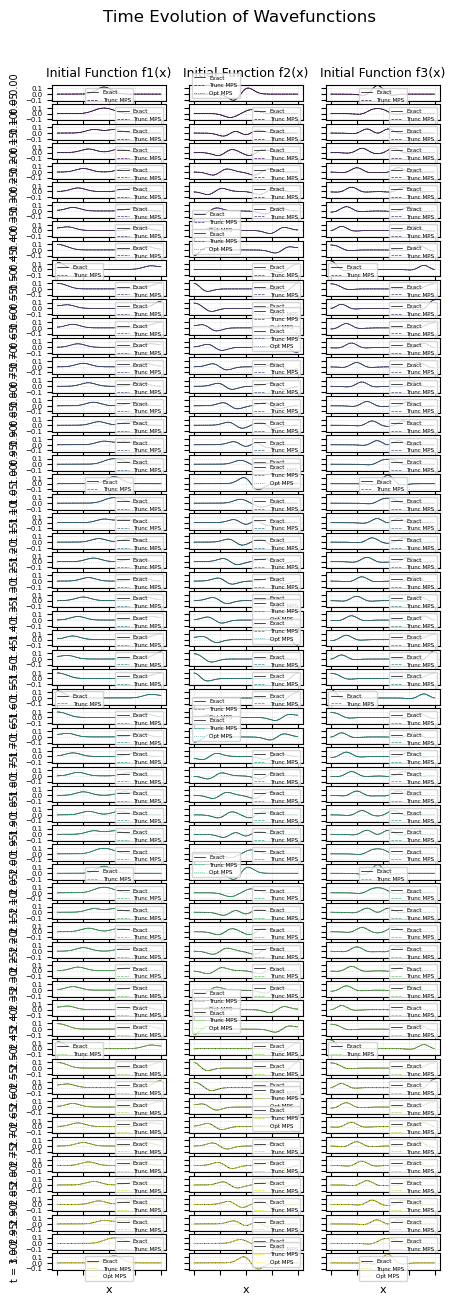

In [6]:
from scipy.linalg import expm 
from matplotlib import cm
from qiskit.quantum_info import Statevector


exact_Hamiltonian = Ham_N(N)
time_steps = 61
dt = 0.05


exact_data = np.zeros((time_steps,3,2*len(x)),dtype=complex)
circuit_data = np.zeros((time_steps,3,2*len(x)),dtype=complex)
opt_circuit_data = np.zeros((time_steps,3,2*len(x)),dtype=complex)
# Reduce figure size for a more compact layout
fig, ax = plt.subplots(time_steps, 3, figsize=(5, 15), sharex=True, sharey=True)
fig.suptitle("Time Evolution of Wavefunctions", fontsize=12,y=0.95)

functions = [f1, f2, f3]
titles = ['Initial Function f1(x)', 'Initial Function f2(x)', 'Initial Function f3(x)']

# Use a colormap to emphasize time evolution
cmap = cm.get_cmap("viridis", time_steps)
colors = [cmap(i) for i in range(time_steps)]

cmap1 = cm.get_cmap("cool", time_steps)
colors1 = [cmap1(i) for i in range(time_steps)]


for col in range(3):
    func = functions[col]
    initial_state = np.concatenate([func(x)/np.linalg.norm(func(x)), np.zeros(x.shape)])
    
    for row in range(time_steps):
        t = row * dt
        evolved_state = expm(-1j * exact_Hamiltonian * t) @ initial_state
        ax[row][col].plot(x, evolved_state[:len(x)].real,color='k',linewidth=0.5,label='Exact')
        ax[row][col].plot(x, Statevector(circs[col].assign_parameters([t]).reverse_bits()).data.real[:len(x)],linestyle='--',color=colors[row],linewidth=0.5,label='Trunc MPS')
        ax[row][col].plot(x, Statevector(circs_opt[col].assign_parameters([t]).reverse_bits()).data.real[:len(x)],linestyle=':',color=colors[row],linewidth=0.5,label='Opt MPS')
        ax[row][col].legend(fontsize=4)
        
        exact_data[row,col,:] = evolved_state
        circuit_data[row,col,:] = Statevector(circs[col].assign_parameters([t]).reverse_bits()).data[:2*len(x)]
        opt_circuit_data[row,col,:] = Statevector(circs_opt[col].assign_parameters([t]).reverse_bits()).data[:2*len(x)]
        
        # Label time on left-most column
        if col == 0:
            ax[row][col].set_ylabel(f"t = {t:.2f}", fontsize=7)
        
        # Set titles on top row
        if row == 0:
            ax[row][col].set_title(titles[col], fontsize=9)

        ax[row][col].tick_params(labelsize=5)  # Smaller tick labels
        ax[row][col].grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

# Hide x-axis labels on all but last row
for row in range(time_steps - 1):
    for col in range(3):
        ax[row][col].set_xticklabels([])

# Set a common x-axis label
for col in range(3):
    ax[-1][col].set_xlabel("x", fontsize=8)

# Adjust layout to reduce space
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.9)  # Reduced hspace for a more compact layout
plt.savefig("../Figures/MPSFullEvolution.pdf",dpi=300)
plt.show()

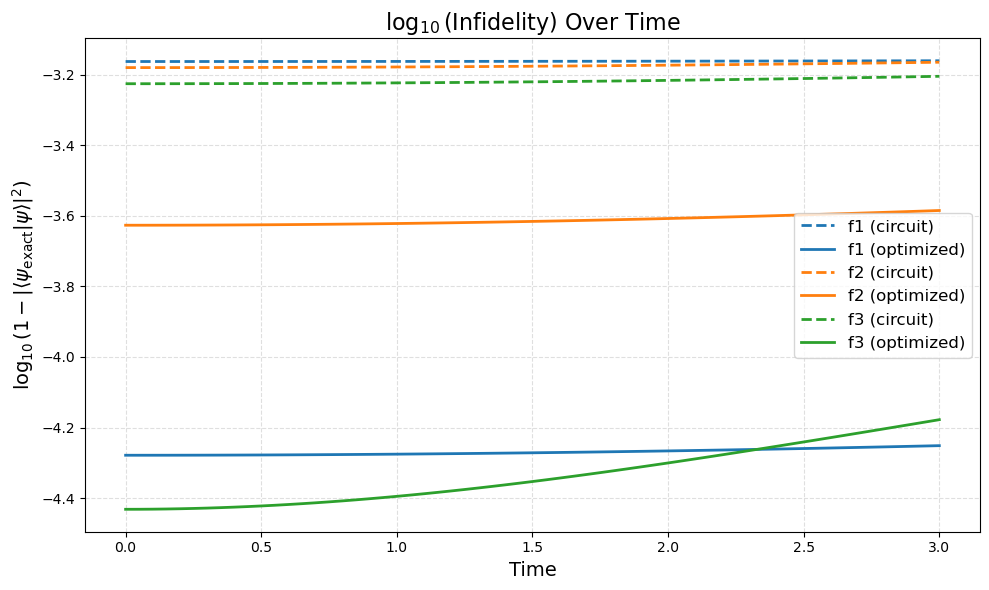

In [8]:
time = np.array(range(time_steps)) * dt
circ_log_infidelities = [
    [np.log10(1 - abs(circuit_data[t, i, :].conjugate() @ exact_data[t, i, :])**2) for t in range(time_steps)]
    for i in range(3)
]

opt_circ_log_infidelities = [
    [np.log10(1 - abs(opt_circuit_data[t, i, :].conjugate() @ exact_data[t, i, :])**2) for t in range(time_steps)]
    for i in range(3)
]

plt.figure(figsize=(10, 6))

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['f1', 'f2', 'f3']

for i in range(3):
    plt.plot(time, circ_log_infidelities[i], label=f'{labels[i]} (circuit)', color=colors[i], linestyle='--', linewidth=2)
    plt.plot(time, opt_circ_log_infidelities[i], label=f'{labels[i]} (optimized)', color=colors[i], linestyle='-', linewidth=2)

plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'$\log_{10}(1 - |\langle \psi_{\mathrm{exact}} | \psi \rangle|^2)$', fontsize=14)
plt.title(r'$\log_{10}$(Infidelity) Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../Figures/InfidelityPlot.pdf", dpi=300)
plt.show()